# Análise dos dados e criação do modelo de machine learning

In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import pymysql
from sklearn.metrics import mean_squared_error
from math import sqrt
from prophet import Prophet
import pickle


### Imporatando os dados da AWS

Primeiramente temos que pegar os dados da AWS e converter em um DataFrame para fazermos nossas análises

In [2]:
#Carregando dados da AWS do arquivo json
with open("aws_mysql_key.json") as aws_keys:
    keys = json.load(aws_keys)
    username = keys['user']
    password = keys['password']
    endpoint = keys['endpoint']
    database_name = keys['databasename']

In [3]:
#Lista com os nomes das criptomoedas que serão armazenadas
crypto_names = ['BTC', 'ETH', 'LTC']

In [44]:
con = pymysql.connect(host=endpoint, user=username, password=password, database=database_name)
cursor = con.cursor()
cursor_query = "SELECT * FROM ETH"
cursor.execute(cursor_query)
data = cursor.fetchall()
column_names = [column[0] for column in cursor.description]
btc_data = []
con.close()
for record in data:
    btc_data.append(dict(zip(column_names , record)))

In [45]:
df_btc = pd.DataFrame.from_dict(btc_data)

### Treinando modelo de machine learning

Para este projeto vamos usar o Prophet do Facebook, que é uma biblioteca muito poderosa desenvolvida para fazer previsões de séries temporais. A função abaixo foi criada para automatizar o treino do modelo com diferentes configurações e tambpem para diferentes criptomoedas, fazendo com que nosso código possa ser reutilizado.

In [46]:
def apply_prophet(data_df, seasonality_mode, n_changepoints, changepoint_prior_scale, test_size):
    """
    Recebe um DataFrame, faz todo seu pre-processamento e aplica o modelo Prophet para fazer previsões
    """

    #Dividindo dados entre treino e teste, com 20 valores para teste e filtrando as colunas
    train_data = data_df[:-test_size][['Date', 'Close']]
    test_data = data_df[-test_size:][['Date', 'Close']]


    #criando dict no formato especifico para o prophet e treinando o modelo
    prophet_df = pd.DataFrame({'ds': train_data.Date, 'y': train_data.Close})
    prophet_model = Prophet(seasonality_mode=seasonality_mode, n_changepoints=n_changepoints, changepoint_prior_scale=changepoint_prior_scale)
    fitted = prophet_model.fit(prophet_df)

    #prevendo valores com dados de treino
    train_predicted = fitted.predict(pd.DataFrame({'ds': train_data.Date}))

    #prevendo valores com dados de teste
    test_predicted = fitted.predict(pd.DataFrame({'ds': test_data.Date}))

    #RMSE dos dados de treino e teste
    rmse_train = sqrt(mean_squared_error(train_data.Close, train_predicted.yhat))
    rmse_test = sqrt(mean_squared_error(test_data.Close, test_predicted.yhat))

    #Retornando um dicionario com os valores
    return {'train_predicted': train_predicted,
            'test_predicted': test_predicted,
            'rmse_train': rmse_train,
            'rmse_test': rmse_test,
            'fitted_model': fitted,
            'test_size': test_size

    }



In [47]:
# Função que plota o valor da criptomoeda e sua previsão
def plot_crypto(crypto_df, trained_object_dict):
    """
    Plota preço historico e a previsão de preço da criptomoeda
    """
    figure = plt.figure(figsize=(15,10))
    plt.plot(crypto_df['Date'], crypto_df['Close'])
    plt.plot(crypto_df[:-trained_object_dict['test_size']]['Date'], trained_object_dict['train_predicted'].yhat, color='green')
    plt.plot(crypto_df[-trained_object_dict['test_size']: len(crypto_df)]['Date'], trained_object_dict['test_predicted'].yhat, color='red')
    plt.show()

In [48]:
btc_treinado = apply_prophet(df_btc, 'multiplicative', 30, 10, 20)

22:02:42 - cmdstanpy - INFO - Chain [1] start processing
22:02:44 - cmdstanpy - INFO - Chain [1] done processing


Depois de treinado nosso modelo vamos verificar a métrica rmse com o bloco decódigo abaixo

In [49]:
print("Resultados:")
print(f"RMSE com dados de treino: {btc_treinado['rmse_train']}")
print(f"RMSE com dados de teste: {btc_treinado['rmse_test']}")

Resultados:
RMSE com dados de treino: 147.73150264817102
RMSE com dados de teste: 84.0241823434274


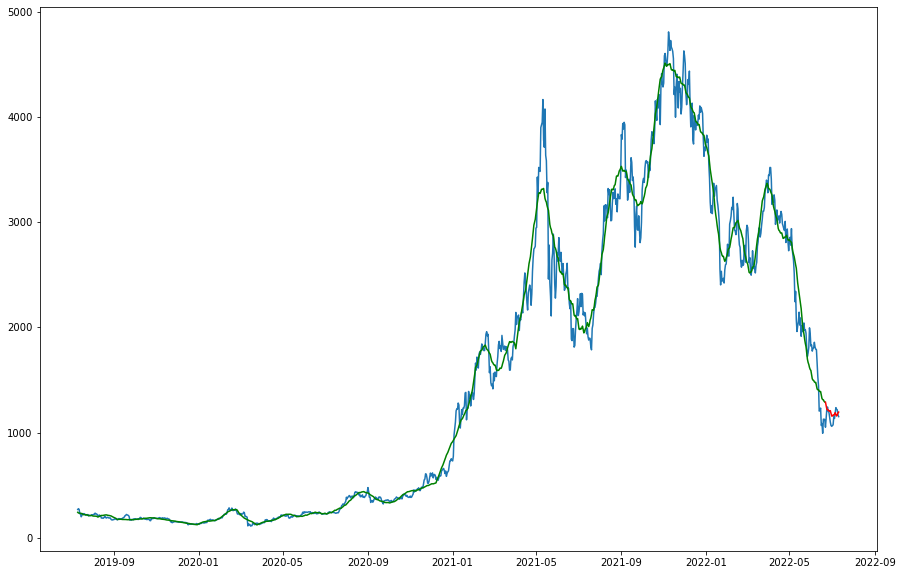

In [50]:
plot_crypto(df_btc, btc_treinado)

### Tunning do algoritmo

Para melhorar a performance do nosso modelo vamos fazer testes exaustivos com diversos parametros e verificar quais apresentam o melhor resultado, ou seja, o menor RMSE

In [34]:
#Parametros que serão testados
n_change = (30, 50, 80, 100, 120, 140, 180)
cp_prior = (5, 8, 10, 12, 16, 20, 25, 30, 35, 40)
seasons = ['multiplicative', 'additive']

In [35]:
def prophet_grid_search(df_crypto, seasonality_mode, n_changepoints, changepoint_prior_scale, test_size):
    """
    Testa todas as combinações das listas de parametros passados no modelo, retorna o melhor grupo de parametros
    """

    best_rmse = 9000
    best_nchange = 0
    best_cprior = 0
    best_seasonality = ""
    for n_c in n_changepoints:

        for prior in changepoint_prior_scale:
            for season in seasonality_mode:
                btc_treinado = apply_prophet(df_crypto, season, n_c, prior, test_size)
                if btc_treinado['rmse_test'] < best_rmse:
                    best_rmse = btc_treinado['rmse_test']
                    best_nchange = n_c
                    best_cprior = prior
                    best_seasonality = season
                print(f"Melhor ate agora: {best_rmse}")
    
    print(f"Melhor RMSE para dados de teste: {best_rmse}\nMelhor nChange: {best_nchange}\nMelhor cp_prior: {best_cprior}\nMelhor Seasonality: {best_seasonality}")




Para usar a função acima basta fazer o chamado conforme o codigo abaixo

In [36]:
prophet_grid_search(df_btc, seasons, n_change, cp_prior, 20)

21:15:39 - cmdstanpy - INFO - Chain [1] start processing
21:15:41 - cmdstanpy - INFO - Chain [1] done processing
21:15:44 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 3.1465775414460073


21:15:46 - cmdstanpy - INFO - Chain [1] done processing
21:15:49 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 3.1465775414460073


21:15:51 - cmdstanpy - INFO - Chain [1] done processing
21:15:53 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.946847251763965


21:15:55 - cmdstanpy - INFO - Chain [1] done processing
21:15:58 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.946847251763965


21:15:59 - cmdstanpy - INFO - Chain [1] done processing
21:16:03 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.946847251763965


21:16:03 - cmdstanpy - INFO - Chain [1] done processing
21:16:07 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.946847251763965


21:16:09 - cmdstanpy - INFO - Chain [1] done processing
21:16:12 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.946847251763965


21:16:13 - cmdstanpy - INFO - Chain [1] done processing
21:16:16 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.946847251763965


21:16:18 - cmdstanpy - INFO - Chain [1] done processing
21:16:21 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:16:22 - cmdstanpy - INFO - Chain [1] done processing
21:16:25 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:16:27 - cmdstanpy - INFO - Chain [1] done processing
21:16:31 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:16:32 - cmdstanpy - INFO - Chain [1] done processing
21:16:35 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:16:37 - cmdstanpy - INFO - Chain [1] done processing
21:16:40 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:16:41 - cmdstanpy - INFO - Chain [1] done processing
21:16:44 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:16:46 - cmdstanpy - INFO - Chain [1] done processing
21:16:49 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:16:51 - cmdstanpy - INFO - Chain [1] done processing
21:16:54 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:16:56 - cmdstanpy - INFO - Chain [1] done processing
21:16:59 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:17:00 - cmdstanpy - INFO - Chain [1] done processing
21:17:03 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:17:05 - cmdstanpy - INFO - Chain [1] done processing
21:17:08 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:17:09 - cmdstanpy - INFO - Chain [1] done processing
21:17:12 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:17:15 - cmdstanpy - INFO - Chain [1] done processing
21:17:19 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:17:22 - cmdstanpy - INFO - Chain [1] done processing
21:17:25 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:17:28 - cmdstanpy - INFO - Chain [1] done processing
21:17:31 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:17:35 - cmdstanpy - INFO - Chain [1] done processing
21:17:38 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:17:40 - cmdstanpy - INFO - Chain [1] done processing
21:17:44 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:17:47 - cmdstanpy - INFO - Chain [1] done processing
21:17:50 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:17:53 - cmdstanpy - INFO - Chain [1] done processing
21:17:56 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:17:59 - cmdstanpy - INFO - Chain [1] done processing
21:18:03 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:18:05 - cmdstanpy - INFO - Chain [1] done processing
21:18:09 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:18:12 - cmdstanpy - INFO - Chain [1] done processing
21:18:15 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:18:18 - cmdstanpy - INFO - Chain [1] done processing
21:18:22 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:18:24 - cmdstanpy - INFO - Chain [1] done processing
21:18:28 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:18:31 - cmdstanpy - INFO - Chain [1] done processing
21:18:35 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:18:37 - cmdstanpy - INFO - Chain [1] done processing
21:18:41 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:18:44 - cmdstanpy - INFO - Chain [1] done processing
21:18:47 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:18:50 - cmdstanpy - INFO - Chain [1] done processing
21:18:54 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:18:57 - cmdstanpy - INFO - Chain [1] done processing
21:19:00 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:19:03 - cmdstanpy - INFO - Chain [1] done processing
21:19:06 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:19:09 - cmdstanpy - INFO - Chain [1] done processing
21:19:12 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:19:15 - cmdstanpy - INFO - Chain [1] done processing
21:19:18 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:19:22 - cmdstanpy - INFO - Chain [1] done processing
21:19:26 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:19:30 - cmdstanpy - INFO - Chain [1] done processing
21:19:34 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:19:39 - cmdstanpy - INFO - Chain [1] done processing
21:19:43 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:19:46 - cmdstanpy - INFO - Chain [1] done processing
21:19:51 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:19:54 - cmdstanpy - INFO - Chain [1] done processing
21:19:59 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:20:03 - cmdstanpy - INFO - Chain [1] done processing
21:20:07 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:20:10 - cmdstanpy - INFO - Chain [1] done processing
21:20:14 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:20:18 - cmdstanpy - INFO - Chain [1] done processing
21:20:22 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:20:27 - cmdstanpy - INFO - Chain [1] done processing
21:20:31 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:20:35 - cmdstanpy - INFO - Chain [1] done processing
21:20:40 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:20:45 - cmdstanpy - INFO - Chain [1] done processing
21:20:50 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:20:55 - cmdstanpy - INFO - Chain [1] done processing
21:20:59 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:21:04 - cmdstanpy - INFO - Chain [1] done processing
21:21:09 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:21:14 - cmdstanpy - INFO - Chain [1] done processing
21:21:19 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:21:23 - cmdstanpy - INFO - Chain [1] done processing
21:21:27 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:21:31 - cmdstanpy - INFO - Chain [1] done processing
21:21:36 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:21:40 - cmdstanpy - INFO - Chain [1] done processing
21:21:44 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:21:48 - cmdstanpy - INFO - Chain [1] done processing
21:21:52 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:21:56 - cmdstanpy - INFO - Chain [1] done processing
21:22:00 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:22:04 - cmdstanpy - INFO - Chain [1] done processing
21:22:08 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:22:13 - cmdstanpy - INFO - Chain [1] done processing
21:22:19 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:22:24 - cmdstanpy - INFO - Chain [1] done processing
21:22:28 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:22:32 - cmdstanpy - INFO - Chain [1] done processing
21:22:37 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:22:42 - cmdstanpy - INFO - Chain [1] done processing
21:22:46 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:22:50 - cmdstanpy - INFO - Chain [1] done processing
21:22:55 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:23:00 - cmdstanpy - INFO - Chain [1] done processing
21:23:04 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:23:10 - cmdstanpy - INFO - Chain [1] done processing
21:23:14 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:23:18 - cmdstanpy - INFO - Chain [1] done processing
21:23:23 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:23:27 - cmdstanpy - INFO - Chain [1] done processing
21:23:32 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:23:37 - cmdstanpy - INFO - Chain [1] done processing
21:23:41 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:23:45 - cmdstanpy - INFO - Chain [1] done processing
21:23:51 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:23:55 - cmdstanpy - INFO - Chain [1] done processing
21:23:59 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:24:05 - cmdstanpy - INFO - Chain [1] done processing
21:24:09 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:24:13 - cmdstanpy - INFO - Chain [1] done processing
21:24:18 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:24:22 - cmdstanpy - INFO - Chain [1] done processing
21:24:28 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:24:32 - cmdstanpy - INFO - Chain [1] done processing
21:24:36 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:24:42 - cmdstanpy - INFO - Chain [1] done processing
21:24:46 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:24:50 - cmdstanpy - INFO - Chain [1] done processing
21:24:55 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:24:59 - cmdstanpy - INFO - Chain [1] done processing
21:25:04 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:25:08 - cmdstanpy - INFO - Chain [1] done processing
21:25:14 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:25:18 - cmdstanpy - INFO - Chain [1] done processing
21:25:24 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:25:29 - cmdstanpy - INFO - Chain [1] done processing
21:25:35 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:25:39 - cmdstanpy - INFO - Chain [1] done processing
21:25:44 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:25:49 - cmdstanpy - INFO - Chain [1] done processing
21:25:54 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:25:59 - cmdstanpy - INFO - Chain [1] done processing
21:26:05 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:26:09 - cmdstanpy - INFO - Chain [1] done processing
21:26:14 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:26:20 - cmdstanpy - INFO - Chain [1] done processing
21:26:25 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:26:30 - cmdstanpy - INFO - Chain [1] done processing
21:26:36 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:26:41 - cmdstanpy - INFO - Chain [1] done processing
21:26:47 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:26:51 - cmdstanpy - INFO - Chain [1] done processing
21:26:57 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:27:02 - cmdstanpy - INFO - Chain [1] done processing
21:27:07 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:27:12 - cmdstanpy - INFO - Chain [1] done processing
21:27:17 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:27:22 - cmdstanpy - INFO - Chain [1] done processing
21:27:27 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:27:33 - cmdstanpy - INFO - Chain [1] done processing
21:27:37 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:27:42 - cmdstanpy - INFO - Chain [1] done processing
21:27:48 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:27:52 - cmdstanpy - INFO - Chain [1] done processing
21:27:57 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:28:03 - cmdstanpy - INFO - Chain [1] done processing
21:28:08 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:28:13 - cmdstanpy - INFO - Chain [1] done processing
21:28:19 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:28:24 - cmdstanpy - INFO - Chain [1] done processing
21:28:28 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:28:33 - cmdstanpy - INFO - Chain [1] done processing
21:28:38 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:28:44 - cmdstanpy - INFO - Chain [1] done processing
21:28:50 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:28:55 - cmdstanpy - INFO - Chain [1] done processing
21:29:01 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:29:07 - cmdstanpy - INFO - Chain [1] done processing
21:29:12 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:29:18 - cmdstanpy - INFO - Chain [1] done processing
21:29:23 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:29:29 - cmdstanpy - INFO - Chain [1] done processing
21:29:34 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:29:40 - cmdstanpy - INFO - Chain [1] done processing
21:29:46 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:29:51 - cmdstanpy - INFO - Chain [1] done processing
21:29:57 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:30:03 - cmdstanpy - INFO - Chain [1] done processing
21:30:08 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:30:15 - cmdstanpy - INFO - Chain [1] done processing
21:30:20 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:30:26 - cmdstanpy - INFO - Chain [1] done processing
21:30:32 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:30:38 - cmdstanpy - INFO - Chain [1] done processing
21:30:43 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:30:49 - cmdstanpy - INFO - Chain [1] done processing
21:30:54 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:31:00 - cmdstanpy - INFO - Chain [1] done processing
21:31:06 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:31:12 - cmdstanpy - INFO - Chain [1] done processing
21:31:17 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:31:22 - cmdstanpy - INFO - Chain [1] done processing
21:31:29 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:31:34 - cmdstanpy - INFO - Chain [1] done processing
21:31:40 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:31:47 - cmdstanpy - INFO - Chain [1] done processing
21:31:52 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:31:58 - cmdstanpy - INFO - Chain [1] done processing
21:32:04 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:32:09 - cmdstanpy - INFO - Chain [1] done processing
21:32:15 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:32:21 - cmdstanpy - INFO - Chain [1] done processing
21:32:26 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:32:34 - cmdstanpy - INFO - Chain [1] done processing
21:32:40 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:32:47 - cmdstanpy - INFO - Chain [1] done processing
21:32:54 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:33:01 - cmdstanpy - INFO - Chain [1] done processing
21:33:08 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:33:15 - cmdstanpy - INFO - Chain [1] done processing
21:33:22 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:33:29 - cmdstanpy - INFO - Chain [1] done processing
21:33:36 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:33:43 - cmdstanpy - INFO - Chain [1] done processing
21:33:49 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:33:58 - cmdstanpy - INFO - Chain [1] done processing
21:34:04 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:34:12 - cmdstanpy - INFO - Chain [1] done processing
21:34:18 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:34:26 - cmdstanpy - INFO - Chain [1] done processing
21:34:33 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:34:40 - cmdstanpy - INFO - Chain [1] done processing
21:34:46 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:34:54 - cmdstanpy - INFO - Chain [1] done processing
21:35:00 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:35:08 - cmdstanpy - INFO - Chain [1] done processing
21:35:14 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:35:22 - cmdstanpy - INFO - Chain [1] done processing
21:35:29 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:35:36 - cmdstanpy - INFO - Chain [1] done processing
21:35:42 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:35:49 - cmdstanpy - INFO - Chain [1] done processing
21:35:56 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:36:04 - cmdstanpy - INFO - Chain [1] done processing
21:36:10 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:36:18 - cmdstanpy - INFO - Chain [1] done processing
21:36:25 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:36:32 - cmdstanpy - INFO - Chain [1] done processing
21:36:39 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:36:46 - cmdstanpy - INFO - Chain [1] done processing
21:36:53 - cmdstanpy - INFO - Chain [1] start processing


Best so far: 2.8034860413989877


21:37:00 - cmdstanpy - INFO - Chain [1] done processing


Best so far: 2.8034860413989877
Best RMSE para dados de teste: 2.8034860413989877
Melhor nChange: 30
Melhor cp_prior: 16
Melhor Seasonality: multiplicative


### Resultados

Depois de executar a função para cada criptomoeda obtivemos os seguintes resultados:

BITCOIN:\
nChange: 100\
Melhor cp_prior: 35\
Melhor Seasonality: multiplicative

ETHEREUM\
Melhor RMSE para dados de teste: 84.0241823434274\
Melhor nChange: 30\
Melhor cp_prior: 10\
Melhor Seasonality: multiplicative

Lightcoin:\
Melhor RMSE para dados de teste: 2.8034860413989877\
Melhor nChange: 30\
Melhor cp_prior: 16\
Melhor Seasonality: multiplicative

### Persistindo o modelo em disco

O bloco de codigo abaixo persiste o modelo para o Bitcoin, para persistir pros outros basta trocar o DataFrame

In [51]:
persist_data = df_btc[['Date', 'Close']]


#criando dict no formato especifico para o prophet e treinando o modelo
prophet_df = pd.DataFrame({'ds': persist_data.Date, 'y': persist_data.Close})

#Criando o modelo
export_model = Prophet(seasonality_mode='multiplicative', n_changepoints=30, changepoint_prior_scale=10)
fitted = export_model.fit(prophet_df)


22:03:28 - cmdstanpy - INFO - Chain [1] start processing
22:03:30 - cmdstanpy - INFO - Chain [1] done processing


In [52]:
#Persistindo o modelo em disco
picle_out = open("eth_predictor.pkl", mode= 'wb')
pickle.dump(fitted, picle_out)
picle_out.close()